<a href="https://colab.research.google.com/github/phimwipha-Stat-352/Pimwipha-StatforData-352/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

[Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

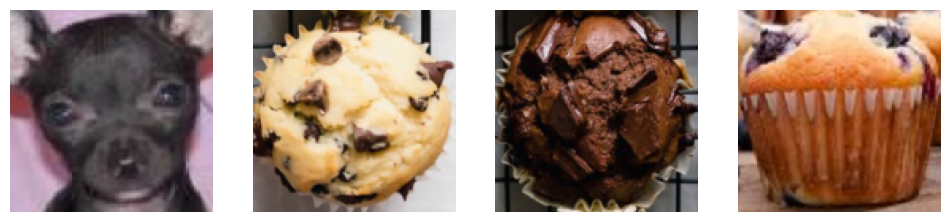

tensor([0, 1, 1, 1])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [9]:
class SimpleLogisticRegression(nn.Module): # Model class
# Attribute --> Layers
  def __init__(self):
    super().__init__()
    # Define layers
    self.flatten = nn.Flatten() # คลี่รูปภาพ
    # linear layer
    self.lin1 = nn.Linear(128 * 128 * 3, 100) # input ตัวที่สองมีความยาว 100
    self.act1 = nn.ReLU() # Activation function
    self.lin2 = nn.Linear(100, 50)
    self.act2 = nn.ReLU() # Activation function
    self.lin3 = nn.Linear(50, 1)

# init เชื่อมต่อกันอย่างไรบ้าง
  def forward(self, x):
    # Forward pass ข้อมูลต้องผ่านตังไหนบ้าง
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [10]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [11]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [12]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [13]:
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [14]:
X, y = next(train_batches) # X : images, y : labels

#### Make a prediction on the minibatch (Forward pass)

In [15]:
y_hat = model(X)
y = y.to(torch.float32)
# Output ---> vector ---> Scalar
y_hat = y_hat[:, 0]

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [16]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss)


In [17]:
train_losses

[tensor(11.5129, grad_fn=<DivBackward1>)]

#### Calculate the gradient (Backward pass)

In [18]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
train_loss.backward()

In [19]:
model.parameters()

<generator object Module.parameters at 0x78cf895b2c00>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [20]:
# Manually update the weights using the gradient descent rule
optimizer.step() # parameter - learning_rate

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [23]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [25]:
print(train_losses)
print(val_losses)

[tensor(11.5129, grad_fn=<DivBackward1>)]
[38.13664627075195, 38.13664627075195]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

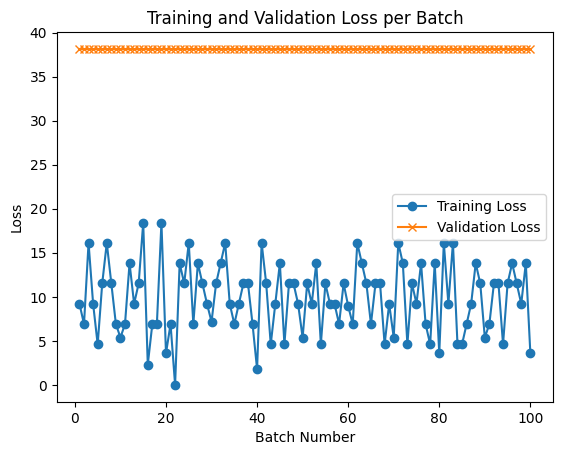

In [26]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [27]:
# Create a neural network with 3 hidden layers as shown in the picture.
class SimpleLogisticRegression(nn.Module): # Model class
# Attribute --> Layers
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.lin1 = nn.Linear(128 * 128 * 3, 128)
    self.act1 = nn.ReLU()
    self.lin2 = nn.Linear(128, 64)
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(64, 32)
    self.act3 = nn.ReLU()
    self.lin4 = nn.Linear(32, 1)

# init เชื่อมต่อกันอย่างไรบ้าง
  def forward(self, x):
    # Forward pass ข้อมูลต้องผ่านตังไหนบ้าง
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    x = self.act3(x)
    x = self.lin4(x)
    return x

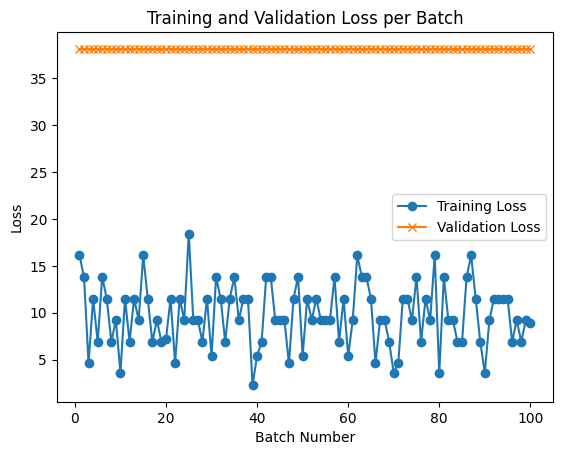

[16.11809730529785, 13.815511703491211, 4.605170249938965, 11.51292610168457, 6.907755374908447, 13.815511703491211, 11.51292610168457, 6.907755374908447, 9.21034049987793, 3.5835189819335938, 11.51292610168457, 6.907755374908447, 11.51292610168457, 9.21034049987793, 16.11809730529785, 11.51292610168457, 6.907755374908447, 9.21034049987793, 6.907755374908447, 7.1670379638671875, 11.51292610168457, 4.605170249938965, 11.51292610168457, 9.21034049987793, 18.420682907104492, 9.21034049987793, 9.21034049987793, 6.907755374908447, 11.51292610168457, 5.375278472900391, 13.815511703491211, 11.51292610168457, 6.907755374908447, 11.51292610168457, 13.815511703491211, 9.21034049987793, 11.51292610168457, 11.51292610168457, 2.3025851249694824, 5.375278472900391, 6.907755374908447, 13.815511703491211, 13.815511703491211, 9.21034049987793, 9.21034049987793, 9.21034049987793, 4.605170249938965, 11.51292610168457, 13.815511703491211, 5.375278472900391, 11.51292610168457, 9.21034049987793, 11.51292610

In [28]:
# Train the model with learning rate
# lr = 1e-2
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(train_losses)
print(val_losses)

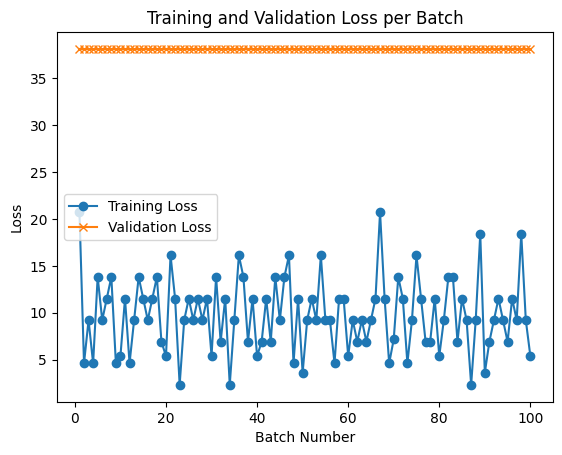

[20.723268508911133, 4.605170249938965, 9.21034049987793, 4.605170249938965, 13.815511703491211, 9.21034049987793, 11.51292610168457, 13.815511703491211, 4.605170249938965, 5.375278472900391, 11.51292610168457, 4.605170249938965, 9.21034049987793, 13.815511703491211, 11.51292610168457, 9.21034049987793, 11.51292610168457, 13.815511703491211, 6.907755374908447, 5.375278472900391, 16.11809730529785, 11.51292610168457, 2.3025851249694824, 9.21034049987793, 11.51292610168457, 9.21034049987793, 11.51292610168457, 9.21034049987793, 11.51292610168457, 5.375278472900391, 13.815511703491211, 6.907755374908447, 11.51292610168457, 2.3025851249694824, 9.21034049987793, 16.11809730529785, 13.815511703491211, 6.907755374908447, 11.51292610168457, 5.375278472900391, 6.907755374908447, 11.51292610168457, 6.907755374908447, 13.815511703491211, 9.21034049987793, 13.815511703491211, 16.11809730529785, 4.605170249938965, 11.51292610168457, 3.5835189819335938, 9.21034049987793, 11.51292610168457, 9.2103404

In [29]:
# Train the model with learning rate
# lr = 1e-3
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(train_losses)
print(val_losses)

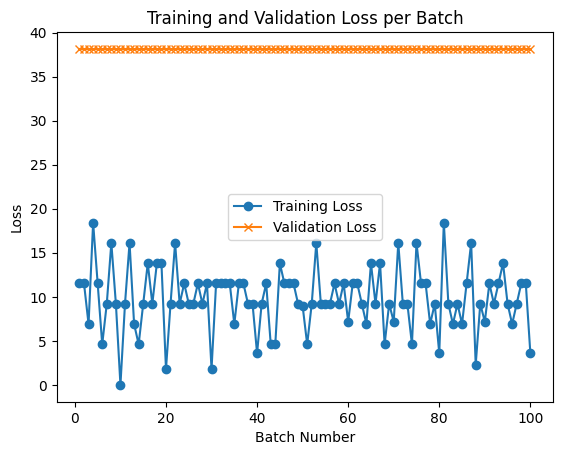

[11.51292610168457, 11.51292610168457, 6.907755374908447, 18.420682907104492, 11.51292610168457, 4.605170249938965, 9.21034049987793, 16.11809730529785, 9.21034049987793, -0.0, 9.21034049987793, 16.11809730529785, 6.907755374908447, 4.605170249938965, 9.21034049987793, 13.815511703491211, 9.21034049987793, 13.815511703491211, 13.815511703491211, 1.7917594909667969, 9.21034049987793, 16.11809730529785, 9.21034049987793, 11.51292610168457, 9.21034049987793, 9.21034049987793, 11.51292610168457, 9.21034049987793, 11.51292610168457, 1.7917594909667969, 11.51292610168457, 11.51292610168457, 11.51292610168457, 11.51292610168457, 6.907755374908447, 11.51292610168457, 11.51292610168457, 9.21034049987793, 9.21034049987793, 3.5835189819335938, 9.21034049987793, 11.51292610168457, 4.605170249938965, 4.605170249938965, 13.815511703491211, 11.51292610168457, 11.51292610168457, 11.51292610168457, 9.21034049987793, 8.958797454833984, 4.605170249938965, 9.21034049987793, 16.11809730529785, 9.2103404998

In [30]:
# Train the model with learning rate
# lr = 1e-4
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(train_losses)
print(val_losses)

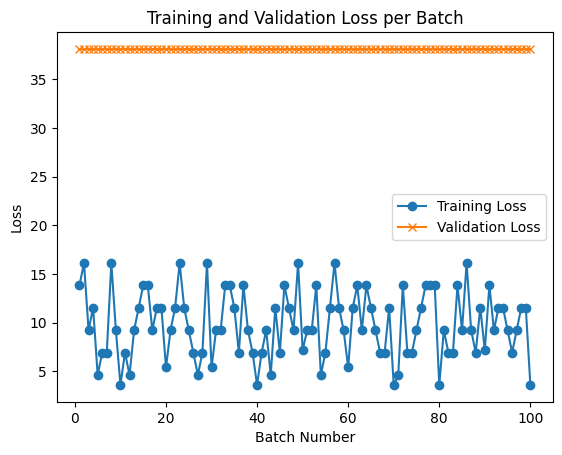

[13.815511703491211, 16.11809730529785, 9.21034049987793, 11.51292610168457, 4.605170249938965, 6.907755374908447, 6.907755374908447, 16.11809730529785, 9.21034049987793, 3.5835189819335938, 6.907755374908447, 4.605170249938965, 9.21034049987793, 11.51292610168457, 13.815511703491211, 13.815511703491211, 9.21034049987793, 11.51292610168457, 11.51292610168457, 5.375278472900391, 9.21034049987793, 11.51292610168457, 16.11809730529785, 11.51292610168457, 9.21034049987793, 6.907755374908447, 4.605170249938965, 6.907755374908447, 16.11809730529785, 5.375278472900391, 9.21034049987793, 9.21034049987793, 13.815511703491211, 13.815511703491211, 11.51292610168457, 6.907755374908447, 13.815511703491211, 9.21034049987793, 6.907755374908447, 3.5835189819335938, 6.907755374908447, 9.21034049987793, 4.605170249938965, 11.51292610168457, 6.907755374908447, 13.815511703491211, 11.51292610168457, 9.21034049987793, 16.11809730529785, 7.1670379638671875, 9.21034049987793, 9.21034049987793, 13.81551170349

In [31]:
# Train the model with learning rate
# lr = 1e-5
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(train_losses)
print(val_losses)

In [32]:
# After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.
# Test set
test_losses = []
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()
  y = y.to(torch.float32)
  test_loss = criterion(y_hat, y)
  test_losses.append(test_loss)

print(test_losses)

[tensor(44.2156)]


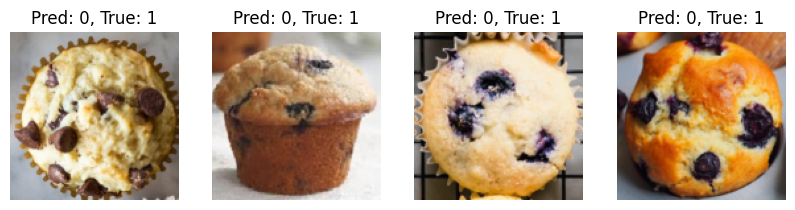

In [33]:
import matplotlib.pyplot as plt
import torch

model.eval()

misclassified_images = []
misclassified_preds = []
misclassified_labels = []

with torch.no_grad():
    for X, y in test_loader:
        logits = model(X).squeeze(1)
        preds = (torch.sigmoid(logits) > 0.5).float()

        for i in range(len(y)):
            if preds[i] != y[i]:
                misclassified_images.append(X[i])
                misclassified_preds.append(preds[i].item())
                misclassified_labels.append(y[i].item())

            if len(misclassified_images) >= 4:
                break
        if len(misclassified_images) >= 4:
            break

plt.figure(figsize=(10, 4))

for i in range(4):
    plt.subplot(1, 4, i + 1)

    img = misclassified_images[i]

    # ถ้าเป็น grayscale (C=1)
    if img.shape[0] == 1:
        plt.imshow(img.squeeze(0), cmap="gray")
    else:
        # (C, H, W) → (H, W, C)
        plt.imshow(img.permute(1, 2, 0))

    plt.title(f"Pred: {int(misclassified_preds[i])}, True: {int(misclassified_labels[i])}")
    plt.axis("off")

plt.show()
